# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review.                     
A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored.                             
This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.               
Here we represented                                                                                                                                          
        1. NEGATIVE REVIEWS=0                                                                                       2. POSITIVE REVIEWS=1


In [0]:
!pip install -U -q Pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plot
!pip install gensim

In [0]:
# authenticate
auth.authenticate_user()
gauth= GoogleAuth()
gauth.credentials= GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

In [0]:
train_downloaded = drive.CreateFile({'id': '1Y-A-8OICeNTz4CDEPN34bQnY4LPeZUli'})
train_downloaded.GetContentFile('Reviews.csv')
df=pd.read_csv('Reviews.csv')
df.shape

(568454, 10)

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



In [0]:
df = pd.read_csv('Reviews.csv')
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


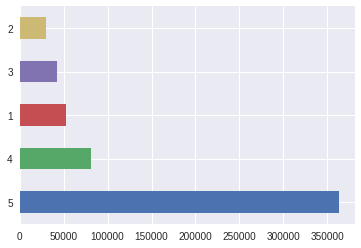

In [0]:

df['Score'].value_counts().plot(kind='barh')

In [0]:
df = df[df.Score != 3]
df.head(2)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


**Here as we only want to get the global sentiment of the recommendations (positive or negative),                   
we will purposefully ignore all Scores equal to 3. If the score id above 3,                                         
then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".**

In [0]:
def partition(x):
    if x < 3:
        return 0
    else:
        return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = df['Score']
positiveNegative = actualScore.map(partition) 
df['Score'] = positiveNegative
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,525814.000000,525814.000000,525814.000000,525814.000000,5.258140e+05
mean,284599.060038,1.747293,2.209544,0.843981,1.295943e+09
std,163984.038077,7.575819,8.195329,0.362874,4.828129e+07
min,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,142730.250000,0.000000,0.000000,1.000000,1.270598e+09
50%,284989.500000,0.000000,1.000000,1.000000,1.310861e+09
75%,426446.750000,2.000000,2.000000,1.000000,1.332634e+09
max,568454.000000,866.000000,878.000000,1.000000,1.351210e+09


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525814 entries, 0 to 568453
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525798 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525789 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 44.1+ MB


In [0]:

df.shape

(525814, 10)

observation
--------
    
1. We consider the label Score to determine weather  a review is positive or negative,so we drop the rows whose Score is 3.        

2.  The text should be converted into a numerical vector



     



DATA CLEANING
-------------------

In [0]:
"""SORTING VALUES USING Time"""
df1=df.sort_values('Time', axis=0, ascending=True,
                   inplace=False, kind='quicksort', na_position='last')
df1.head(2)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...


In [0]:
"""Removing duplicates#DATA CLEANING"""
df2=df1.drop_duplicates(subset={'UserId','Time','Text'},
                        keep='first',inplace=False)
df2.shape

(364133, 10)

In [0]:
df2=df2[df2.HelpfulnessNumerator<=df2.HelpfulnessDenominator]
df2.shape

(364131, 10)



IT IS OBSERVED THAT ALMOST  20000 ENTRIES ARE DUPLICATE ENTRIES 
----------
     1. FOR BETTER PREDICTION OF RESULTS DATA SHOULD BE UNBIASED SO DUPLICATE ENTRIES ARE REMOVED               2.THERE IS MISMATCH IN HELPFULLNESS NUMERATOR AND DEMOMONATOR,AS NUMERATOR <=DEMONINATOR 
    THE ERROR ENTRIES ARE REMOVED

In [0]:

df2['Score'].value_counts(normalize=True)


1    0.843175
0    0.156825
Name: Score, dtype: float64



# TEXT PROCESSING  USING VARIOUS TECHNIQUES

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Convert the word to lowercase
5. Remove Stopwords
6. Finally porter Stemming the word

After which we collect the words used to describe positive and negative reviews

In [0]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('stopwords')
ps = PorterStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))


{'which', "weren't", 'out', 'off', 'having', 'between', 'where', "should've", "you'd", "hadn't", 'the', 'during', 'against', 'as', 'me', "haven't", "wasn't", 'couldn', 'himself', 'because', 'more', "mightn't", 'of', 'being', 'my', 'but', 'o', 'his', 'few', 'same', 'll', 'most', 'above', 'shouldn', 'doesn', "aren't", 'them', 'at', 'it', "wouldn't", 'while', "you're", 'their', 'to', 'themselves', 'yours', 'such', 'didn', 'that', 'him', 'why', "won't", "shan't", 'nor', "mustn't", 'myself', 'am', 'other', 'by', 'own', 'in', "didn't", 'its', 'over', 'ours', 'can', 'each', 'mightn', 'now', 'just', 're', "isn't", 'too', "it's", 'about', 'should', 'be', "you'll", 've', 'mustn', 'once', 'below', 'd', 'wouldn', 'down', 'when', 'so', 'any', 'isn', 'weren', 'only', 'have', "hasn't", 'wasn', 'her', 'than', 'needn', 'your', 'a', 'or', 'until', 'under', 'those', 'hadn', 'had', 'no', 'from', 'this', 'haven', 'y', "you've", 'if', 'theirs', 'he', 'then', 'she', "don't", 'they', "shouldn't", 'these', 'al

In [0]:

def preProcessString(text):
    text = re.sub('<.*?>', ' ', str(text))
    
    '''remove all special characters'''
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    """converting all text into small letters and store
    them as words for furthur processing"""
    text_list = text.lower().split()
    
    '''removing stopwords from the text'''
    english_stop_words = set(stopwords.words('english'))
    '''we have used set instead of list because,
    set uses hashing to store the words. So lookup is O(1)'''.
    text_list = [word for word in text_list if word not in english_stop_words]
    
    '''stemming the words (removing prefix and postfix) 
    using Porter stemming algorithm..'''
    text_list = [ps.stem(word) for word in text_list]
    
    return ' '.join(text_list)

    

In [0]:
df2['Summary'] = df2['Summary'].apply(preProcessString)


In [0]:
df2['Text'] = df2['Text'].apply(preProcessString)


In [0]:
df2 = df2.filter(['Score','Summary','Time','Text'], axis = 1)
df2.head(2)


,Score,Summary,Time,Text
150523,1,EVERY book is educational,939340800,this witty little book makes my son laugh at l...
150500,1,This whole series is great way to spend time w...,940809600,I can remember seeing the show when it aired o...


In [0]:
data=df2.to_csv('final.csv',index=False)
data = pd.read_csv('final.csv')

In [0]:
final=data.sample(n=2000 ,replace=True,random_state=None, axis=0)
final.shape

(2000, 4)

In [0]:
l=final['Score']
d = final.drop("Score",axis=1)
l.head(3)

129211    1
16786     1
14362     1
Name: Score, dtype: int64

In [0]:
l.shape

(2000,)

In [0]:
d.head(2)

,Summary,Time,Text
129211,Excellent coffee!,1292803200,"When I bought my Keurig Brewer for home use, I..."
16786,Agave Nectar Sticks - Two Thumbs up!,1191110400,These are great to carry in your purse or back...


In [0]:
l.value_counts(normalize=True)

1    0.845
0    0.155
Name: Score, dtype: float64

*T-SNE Visualization Using TF-IDF*
====

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',  # features made of words
    ngram_range=(1, 2))

tfidf_df = tfidf_vectorizer.fit_transform(d['Text'])

In [0]:
print(tfidf_df.shape)
print(l.shape) 

(2000, 68374)
(2000,)


In [0]:
X = tfidf_df.todense()

In [0]:
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2, perplexity=30,
                  n_iter=2000, metric='euclidean',verbose=1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 8.209s...
[t-SNE] Computed neighbors for 2000 samples in 692.946s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.181741
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.542122
[t-SNE] Error after 2000 iterations: 2.398696


In [0]:
X_embed = np.vstack((X_embedded.T,l.T)).T
tsne_df = pd.DataFrame(data=X_embed,columns=('Dim_1','Dim_2','label'))
tsne_df.to_csv('tfidf.csv')


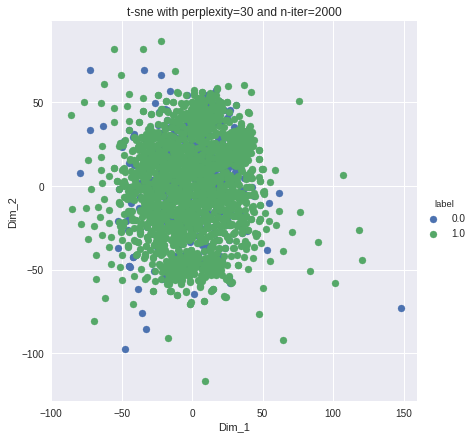

In [0]:
point =pd.read_csv('tfidf.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=30 and n-iter=2000')
plt.show()

In [0]:
X_embedded1 = TSNE(n_components=2, perplexity=15,
                   n_iter=1500, metric='euclidean',verbose=1).fit_transform(X)
X_embedded2 = TSNE(n_components=2, perplexity=10,
                   n_iter=500, metric='euclidean',verbose=1).fit_transform(X)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2000 samples in 8.797s...
[t-SNE] Computed neighbors for 2000 samples in 716.002s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.174241
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.717140
[t-SNE] Error after 1500 iterations: 2.454906
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2000 samples in 8.503s...
[t-SNE] Computed neighbors for 2000 samples in 719.850s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.168720
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.047348
[t-SNE] Error after 500 iterations: 2.504839


In [0]:
X_embedded.shape
X_embedded1.shape
X_embedded2.shape

(2000, 2)

In [0]:
X_embedded1 = np.vstack((X_embedded1.T,l.T)).T
tsne_df1 = pd.DataFrame(data=X_embedded1,columns=('Dim_1','Dim_2','label'))
tsne_df1.to_csv('tfidf1.csv')

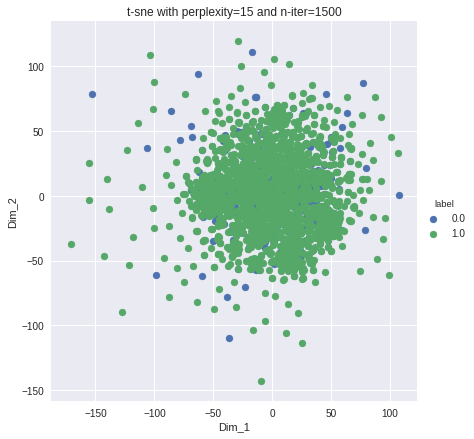

In [0]:
point =pd.read_csv('tfidf1.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=15 and n-iter=1500')
plt.show()

In [0]:
X_embedded2 = np.vstack((X_embedded2.T,l.T)).T
tsne_df2 = pd.DataFrame(data=X_embedded2,columns=('Dim_1','Dim_2','label'))
tsne_df2.to_csv('tfidf2.csv')

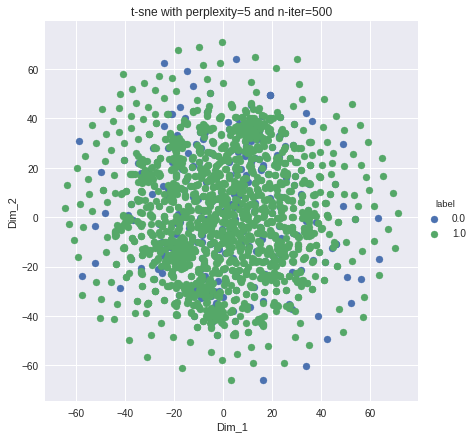

In [0]:
point =pd.read_csv('tfidf2.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=5 and n-iter=500')
plt.show()


 USING BAG OF WORDS
 =====

In [0]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(d['Text'].values)


In [0]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [0]:
final_counts.get_shape()

(2000, 6916)

In [0]:
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
dense = final_counts.todense()
X_BOW = TSNE(n_components=2, perplexity=2,
             n_iter=1000, metric='euclidean',verbose=1).fit_transform(dense)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2000 samples in 1.150s...
[t-SNE] Computed neighbors for 2000 samples in 76.244s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.700746
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.199585
[t-SNE] Error after 1000 iterations: 3.127932


In [0]:
X_BOW1 = TSNE(n_components=2, perplexity=10,
              n_iter=2000, metric='euclidean',verbose=1).fit_transform(dense)

X_BOW2 = TSNE(n_components=2, perplexity=30,
              n_iter=1500, metric='euclidean',verbose=1).fit_transform(dense)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.596s...
[t-SNE] Computed neighbors for 2000 samples in 75.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.081489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 134.019135
[t-SNE] Error after 2000 iterations: 3.248881
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.776s...
[t-SNE] Computed neighbors for 2000 samples in 75.933s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.275459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 119.346062
[t-SNE] Error after 1500 iterations: 2.840192


In [0]:
X_BOW.shape
X_BOW1.shape
X_BOW2.shape

(2000, 2)

In [0]:
X_BOW = np.vstack((X_BOW.T,l.T)).T
BOW_df = pd.DataFrame(data=X_BOW,columns=('Dim_1','Dim_2','label'))

In [0]:
X_BOW1 = np.vstack((X_BOW1.T,l.T)).T
BOW_df1 = pd.DataFrame(data=X_BOW1,columns=('Dim_1','Dim_2','label'))

In [0]:
X_BOW2 = np.vstack((X_BOW2.T,l.T)).T
BOW_df2 = pd.DataFrame(data=X_BOW2,columns=('Dim_1','Dim_2','label'))

In [0]:
BOW_df.to_csv('BOW.csv')
BOW_df1.to_csv('BOW1.csv')
BOW_df2.to_csv('BOW2.csv')

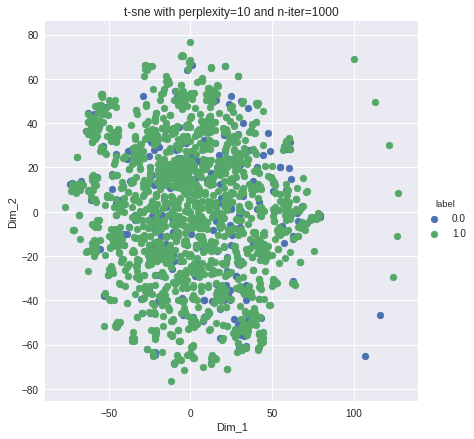

In [0]:
point =pd.read_csv('BOW.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=10 and n-iter=1000')
plt.show()


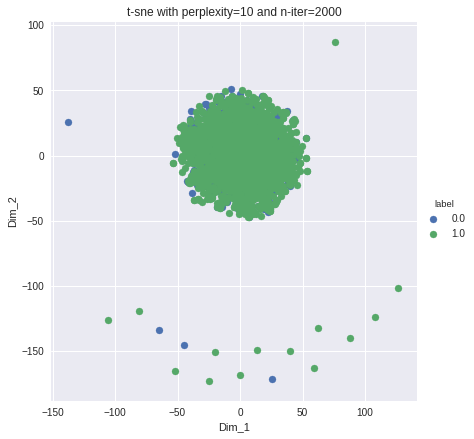

In [0]:
point =pd.read_csv('BOW1.csv')
sns.FacetGrid(data=point,hue='label',size=6) 
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=10 and n-iter=2000')
plt.show()


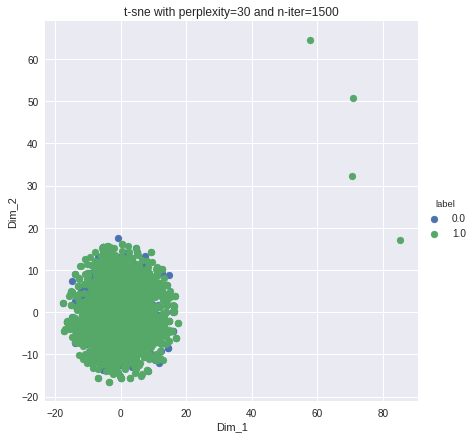

In [0]:
point =pd.read_csv('BOW2.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=30 and n-iter=1500')
plt.show()


  *T-SNE VISUALIZATION USING  AVERAGE WORD TO VEC *
  ---------
 

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
i=0 
sent_list=[]
for sent in d['Text'].values:
    sent_list.append(sent.split())
len(sent_list)

2000

In [0]:
w2v_model=Word2Vec(sent_list,min_count=3,size=100,workers=4)
len(list(w2v_model.wv.vocab))

3024

In [0]:
w2v=list(w2v_model.wv.vocab)
avg_vec=[]
for sentence in sent_list:
    sent_vec=np.zeros(100)
    word_cnt=0
    for words in sent:
        if words in w2v:
        vect= w2v_model.wv[words]
        sent_vec+=vect
        word_cnt += 1
    if word_cnt!=0:
        sent_vec /=word_cnt
    avg_vec.append(sent_vec)
print(len(avg_vec))
print(len(avg_vec[0]))

2000
100


In [0]:
X_w2v = TSNE(n_components=2, perplexity=5,
             n_iter=2000,metric='euclidean',verbose=1).fit_transform(avg_vec)


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.023s...
[t-SNE] Computed neighbors for 2000 samples in 1.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 156.689178
[t-SNE] Error after 1100 iterations: 4.157347


In [0]:
X_w2v1 = TSNE(n_components=2, perplexity=50,
     n_iter=3000, metric='euclidean',verbose=1).fit_transform(avg_vec)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.016s...
[t-SNE] Computed neighbors for 2000 samples in 1.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.930641
[t-SNE] Error after 1300 iterations: 1.755899


In [0]:
X_w2v2 = TSNE(n_components=2, perplexity=30, 
        n_iter=2500, metric='euclidean',verbose=1).fit_transform(avg_vec)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.025s...
[t-SNE] Computed neighbors for 2000 samples in 1.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.100853
[t-SNE] Error after 950 iterations: 2.242168


In [0]:
X_w2v = np.vstack((X_w2v.T,l.T)).T
w2v = pd.DataFrame(data=X_w2v,columns=('Dim_1','Dim_2','label'))


In [0]:
X_w2v1 = np.vstack((X_w2v1.T,l.T)).T
w2v1= pd.DataFrame(data=X_w2v1,columns=('Dim_1','Dim_2','label'))


In [0]:
X_w2v2 = np.vstack((X_w2v2.T,l.T)).T
w2v2= pd.DataFrame(data=X_w2v1,columns=('Dim_1','Dim_2','label'))


In [0]:
w2v.to_csv('w2v.csv')
w2v1.to_csv('w2v1.csv')
w2v2.to_csv('w2v2.csv')


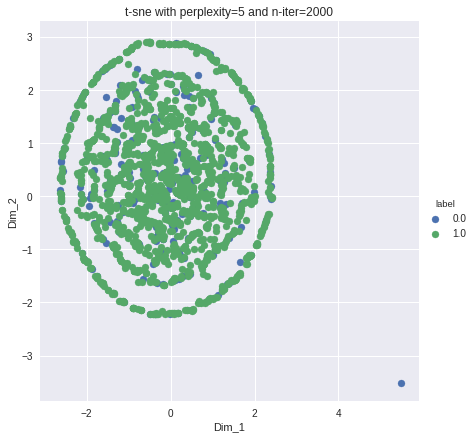

In [0]:
point =pd.read_csv('w2v.csv')
sns.FacetGrid(data=point,hue='label',size=6) 
       .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=5 and n-iter=2000')
plt.show()


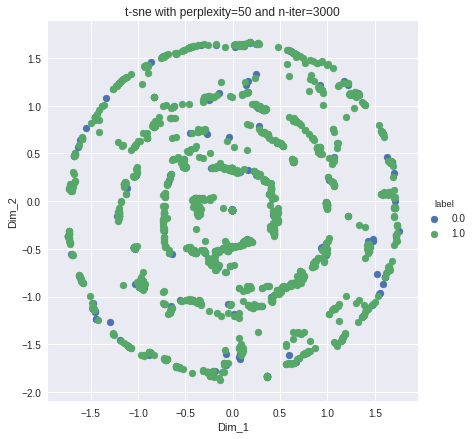

In [0]:
point =pd.read_csv('w2v1.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=50 and n-iter=3000')
plt.show()


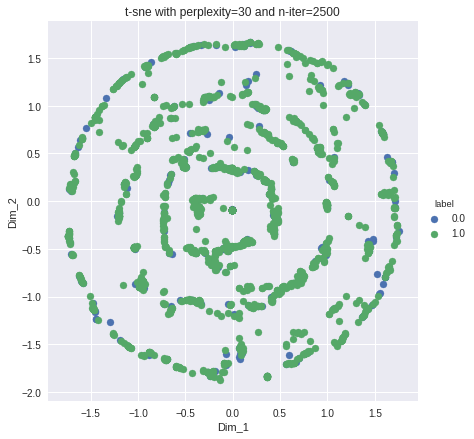

In [0]:
point =pd.read_csv('w2v2.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=30 and n-iter=2500')
plt.show()

*TF-IDF WORD 2 VEC*
===

In [0]:
import gensim
i=0
list_of_sent=[]
for sent in d['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,
                                 size=50, workers=4)



In [0]:
w2v_model.wv.similarity('girl', 'boy')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9928943

In [0]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(d['Text'])

In [0]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
#print(list_of_sent[0])
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent[0:2000]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
       

In [0]:
w2v = TSNE(n_components=2, perplexity=15, n_iter=1500, metric='euclidean',verbose=1)
      .fit_transform(tfidf_sent_vectors)


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.010778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.897869
[t-SNE] Error after 1500 iterations: 0.706554


In [0]:
w2v1 = TSNE(n_components=2, perplexity=2, n_iter=3000, metric='euclidean',verbose=1)
       .fit_transform(tfidf_sent_vectors)
w2v2 = TSNE(n_components=2, perplexity=50, n_iter=4000, metric='euclidean',verbose=1)
       .fit_transform(tfidf_sent_vectors)


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.004229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.754349
[t-SNE] Error after 3000 iterations: 0.854117
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.017227
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.236973
[t-SNE] Error after 4000 iterations: 0.409880


In [0]:
w2v = np.vstack((w2v.T,l.T)).T
w2v_tf= pd.DataFrame(data=w2v,columns=('Dim_1','Dim_2','label'))


In [0]:
w2v1 = np.vstack((w2v1.T,l.T)).T
w2v_tf1= pd.DataFrame(data=w2v1,columns=('Dim_1','Dim_2','label'))


In [0]:
w2v2 = np.vstack((w2v2.T,l.T)).T
w2v_tf2= pd.DataFrame(data=w2v2,columns=('Dim_1','Dim_2','label'))


In [0]:
w2v_tf.to_csv('w2v_tf.csv')
w2v_tf1.to_csv('w2v1_tf.csv')
w2v_tf2.to_csv('w2v2_tf.csv')


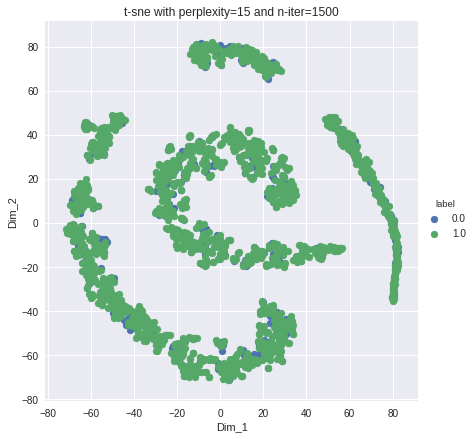

In [0]:
point =pd.read_csv('w2v_tf.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=15 and n-iter=1500')
plt.show()


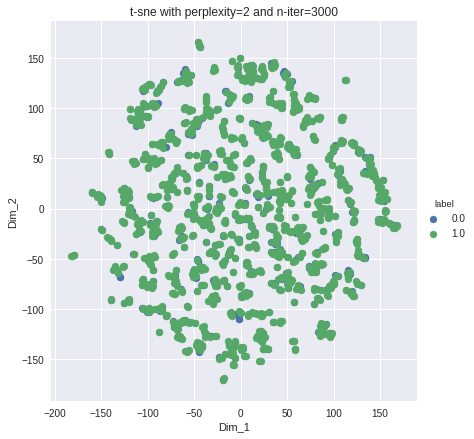

In [0]:
point =pd.read_csv('w2v1_tf.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=2 and n-iter=3000')
plt.show()


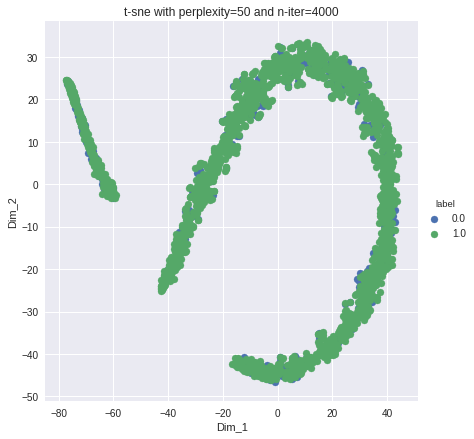

In [0]:
point =pd.read_csv('w2v2_tf.csv')
sns.FacetGrid(data=point,hue='label',size=6)
   .map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title('t-sne with perplexity=50 and n-iter=4000')
plt.show()
